# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [ ]:
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: вероятности принажлежности классу 1

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


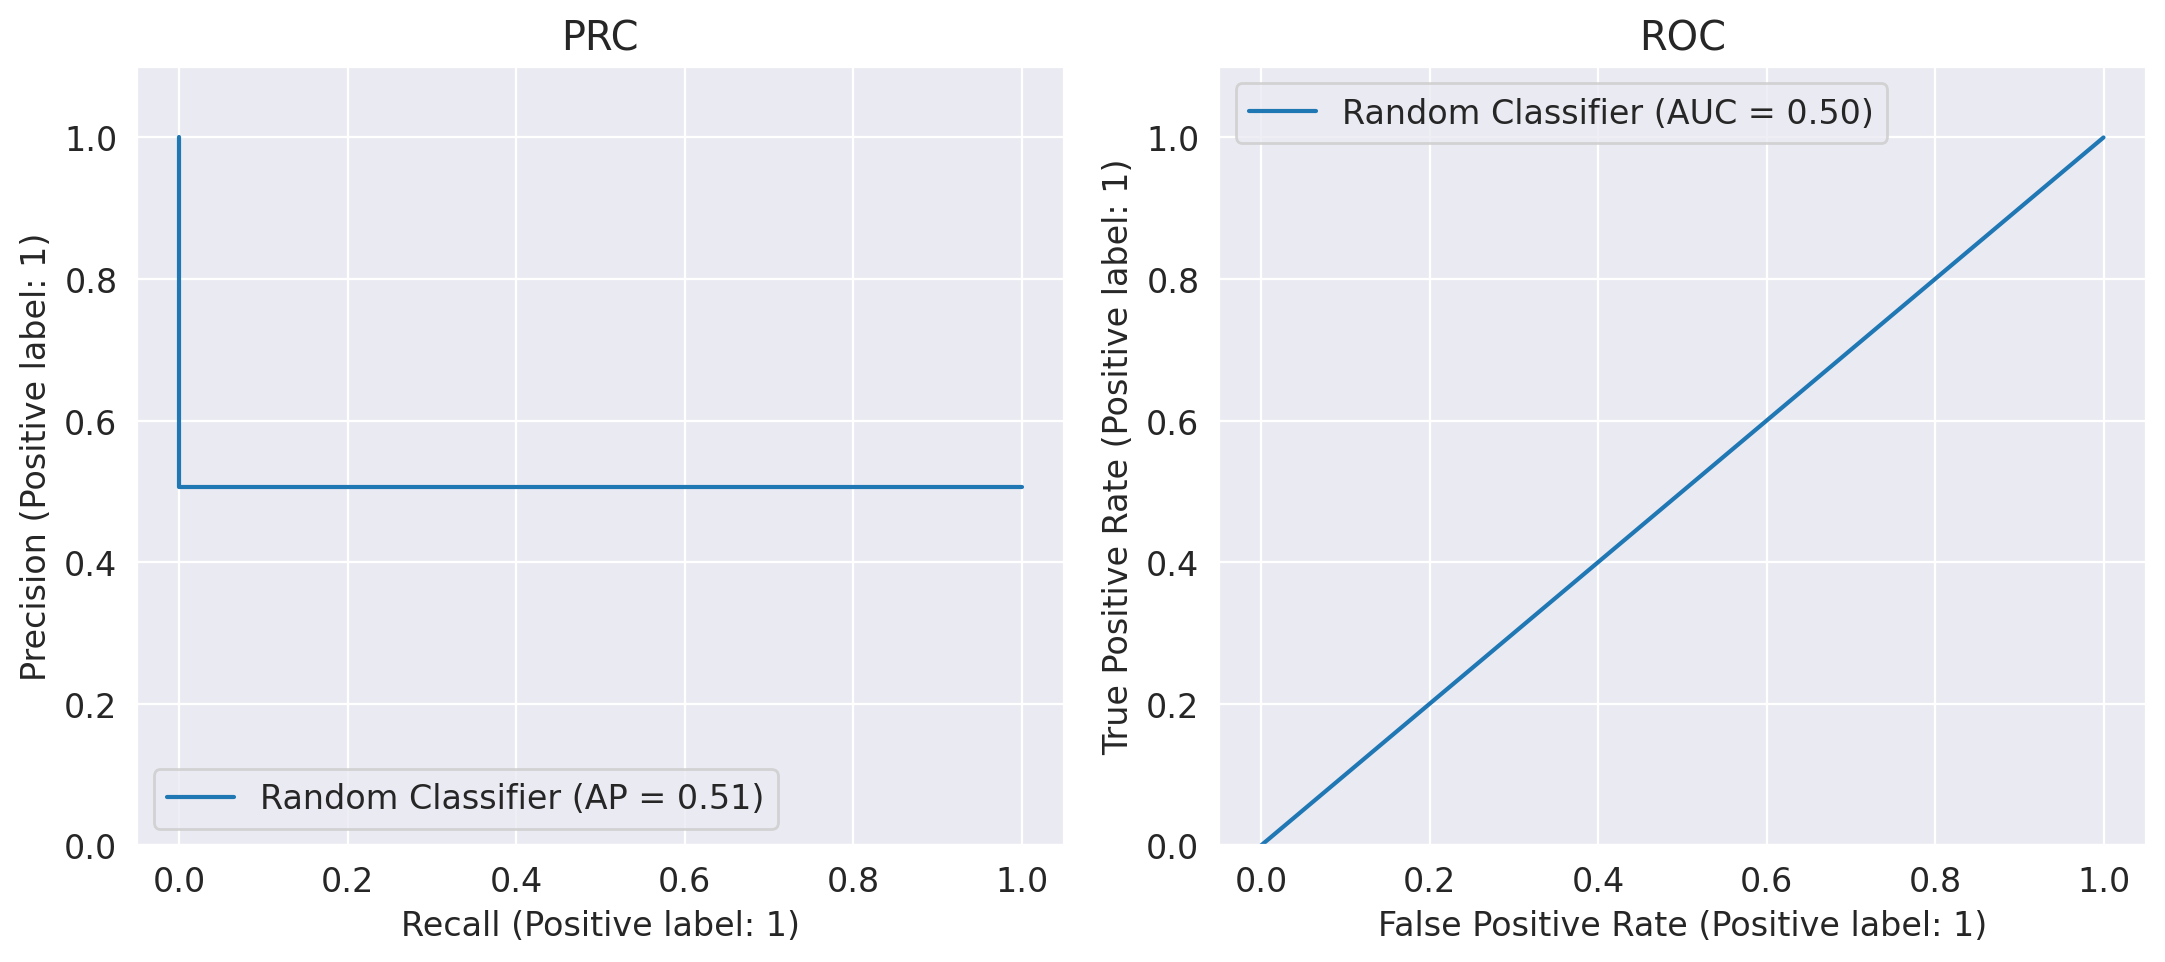

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
estimators = [('scaler', StandardScaler()), ('clf', SVC(kernel='linear', probability=True))]
pipe = Pipeline(estimators)

C = np.linspace(1e-3, 2, 10)
searcher = GridSearchCV(pipe, [{"clf__C": C}], scoring="average_precision", cv=3)
searcher.fit(X_train, y_train)
best_C_svm = searcher.best_params_['clf__C']
print("best C:", best_C_svm)

best C: 0.001


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [ ]:
def draw_auc(y_test, pred, label="SVM"):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    PrecisionRecallDisplay.from_predictions(y_test, pred, ax=ax[0])
    precision, recall, _ = precision_recall_curve(y_test, pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title(label + " PR curve")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_test, pred, ax=ax[1])
    print('AUC-ROC: %.5f' % roc_auc_score(y_test, pred))
    ax[1].set_title(label + " ROC curve")
    ax[1].set_ylim(0, 1.1)

AUC-PR: 0.82108
AUC-ROC: 0.84610


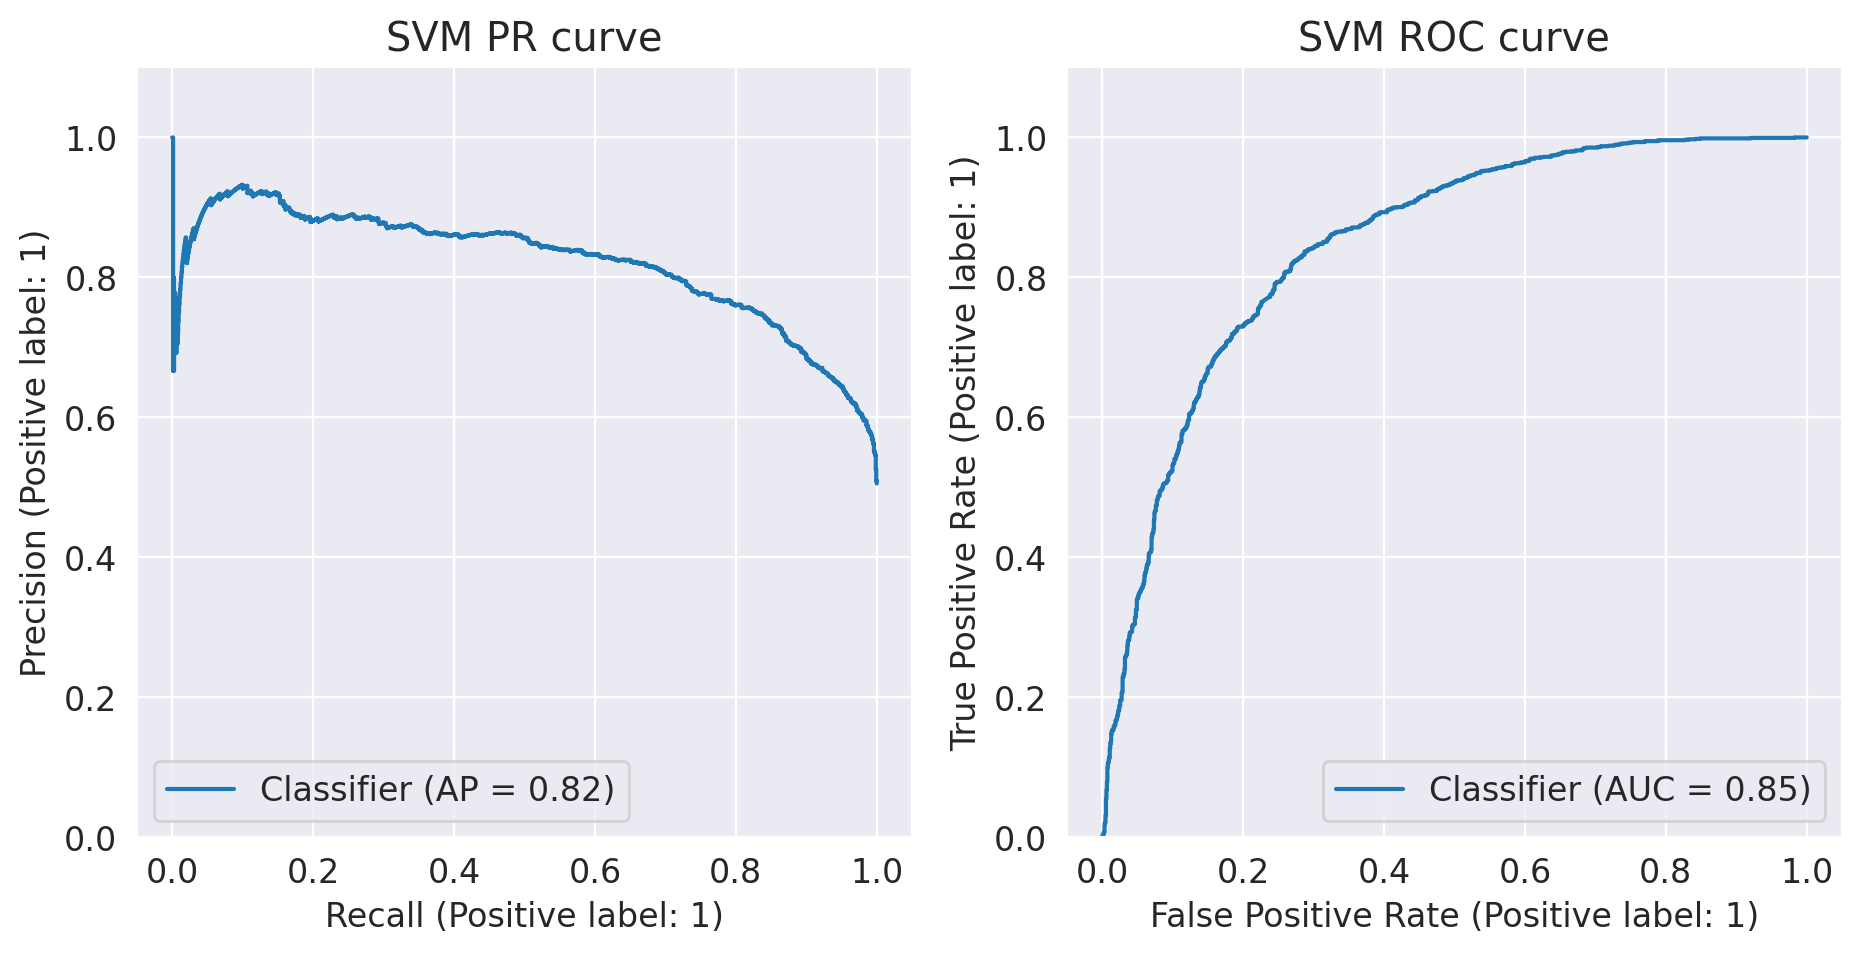

In [ ]:
pipe.set_params(clf__C=best_C_svm)
pipe.fit(X_train, y_train)
pred = pipe.predict_proba(X_test)[:, 1]

draw_auc(y_test, pred)

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

estimators = [('scaler', StandardScaler()),
              ('clf', LogisticRegression(penalty='l2'))]
pipe = Pipeline(estimators)

C = np.linspace(1e-5, 10, 30)
searcher = GridSearchCV(pipe, [{"clf__C": C}], scoring="average_precision", cv=3)
searcher.fit(X_train, y_train)
best_C = searcher.best_params_['clf__C']
print("best C: ", best_C)

pipe.set_params(clf__C=best_C_svm)
pipe.fit(X_train, y_train)
pred_lr = pipe.predict_proba(X_test)[:, 1]


best C:  0.3448372413793104


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

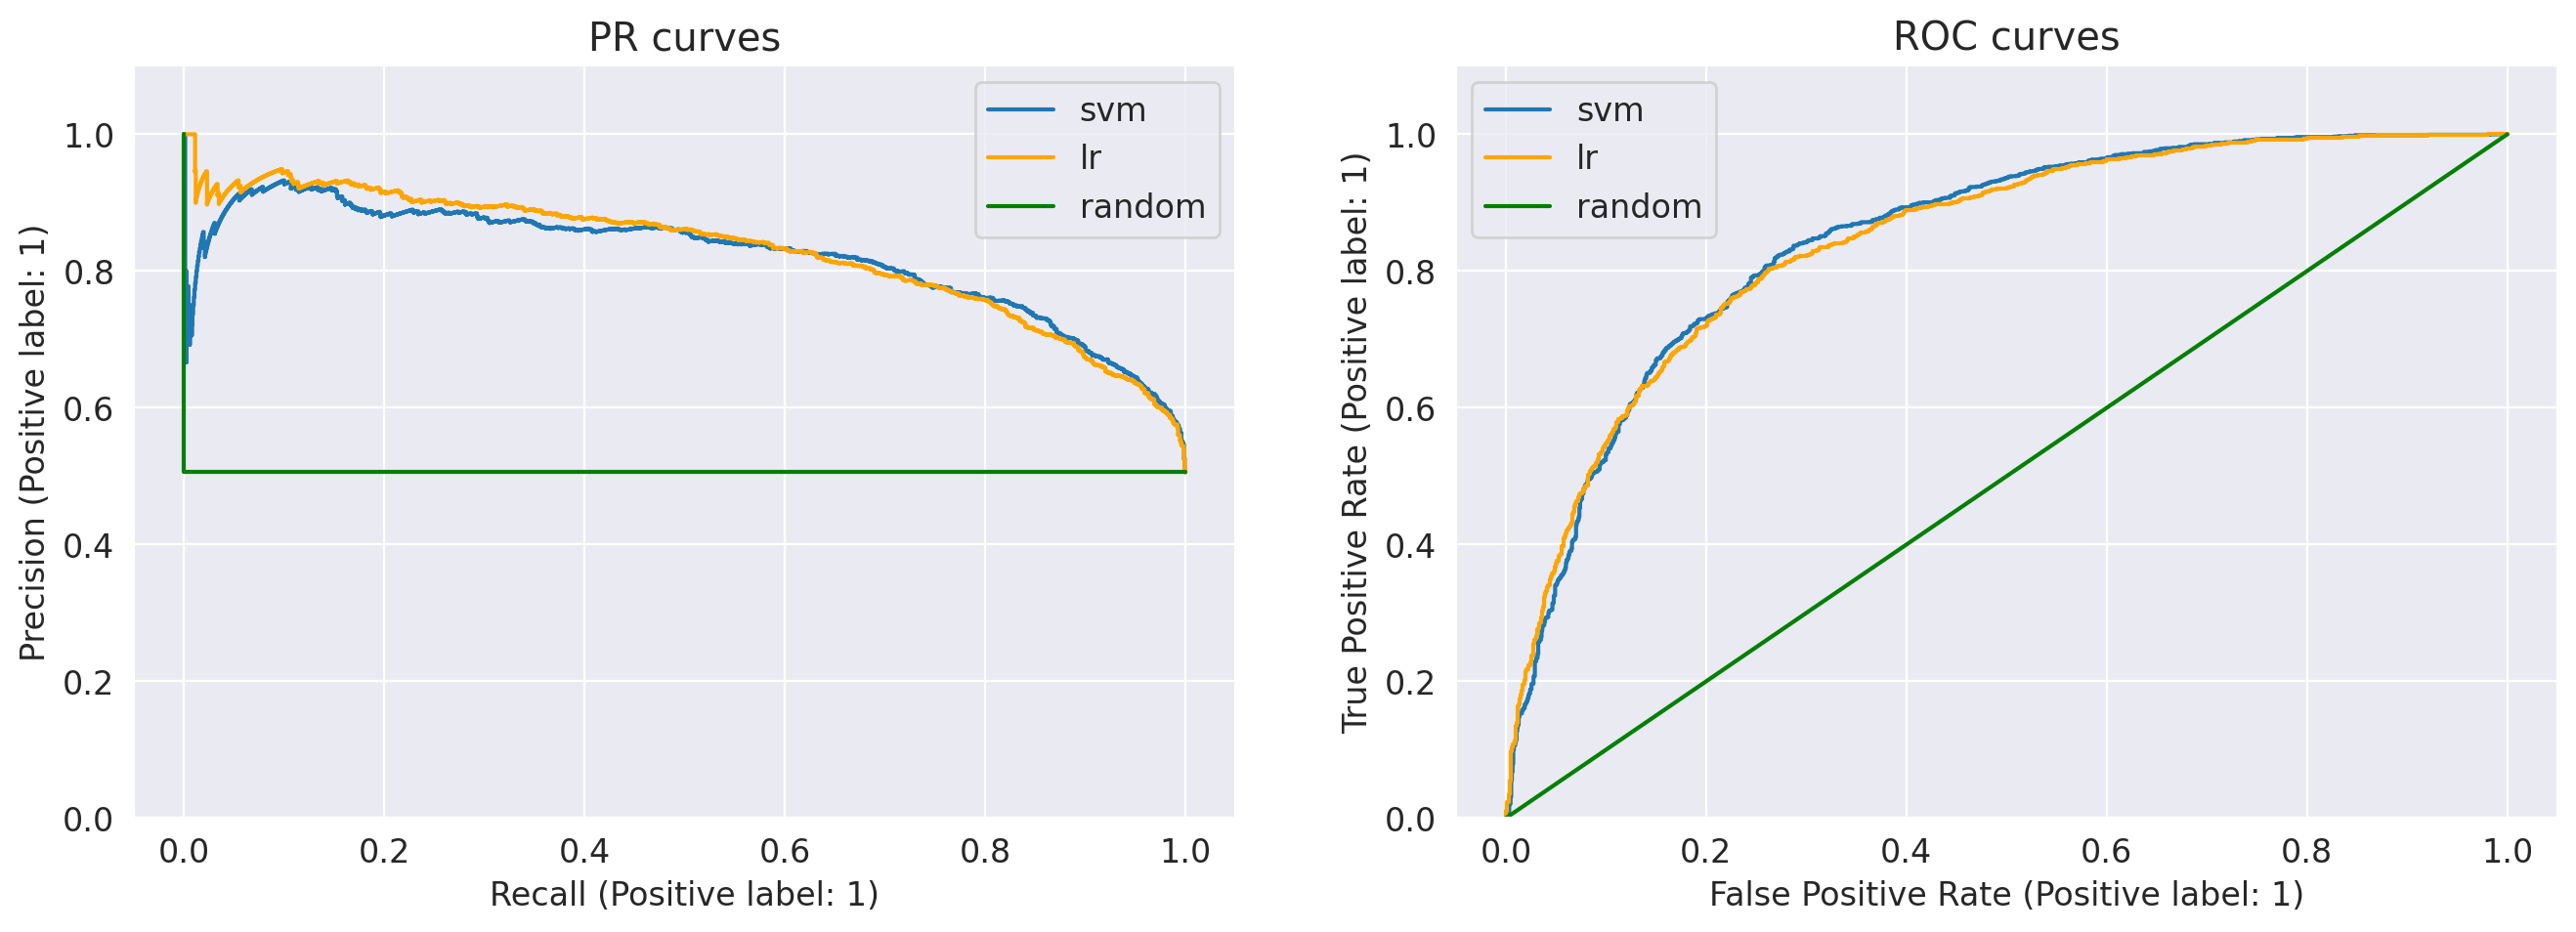

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
# fit SVM
estimators = [('scaler', StandardScaler()), ('clf', SVC(kernel='linear', probability=True))]
pipe = Pipeline(estimators)
pipe.set_params(clf__C=best_C_svm)
pipe.fit(X_train, y_train)
pred_svm = pipe.predict_proba(X_test)[:, 1]

# precision_svm, recall_svm, _ = precision_recall_curve(y_test, pred_svm)
# precision_lr, recall_lr, _ = precision_recall_curve(y_test, pred_lr)

# display
PrecisionRecallDisplay.from_predictions(y_test, pred_svm, ax=ax[0], label="svm")
PrecisionRecallDisplay.from_predictions(y_test, pred_lr, ax=ax[0], color="orange", label="lr")
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], color="green", label="random")

RocCurveDisplay.from_predictions(y_test, pred_svm, ax=ax[1], label="svm")
RocCurveDisplay.from_predictions(y_test, pred_lr, ax=ax[1], label="lr", color="orange")
RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], label="random", color="green")

ax[0].set_title("PR curves")
ax[0].set_ylim(0, 1.1)
ax[1].set_title("ROC curves")
ax[1].set_ylim(0, 1.1)
ax[0].legend()
ax[1].legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** # your answer here

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=42
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])
pipe.fit(X, y)
pred = pipe.predict(X)

clf = pipe['clf']

def get_random_subsampling(X, cnt=30):
    assert cnt <= X.shape[0]
    X_copy = X.copy()
    np.random.shuffle(X_copy)
    return X_copy[:cnt]

Text(0, 0.5, 'y')

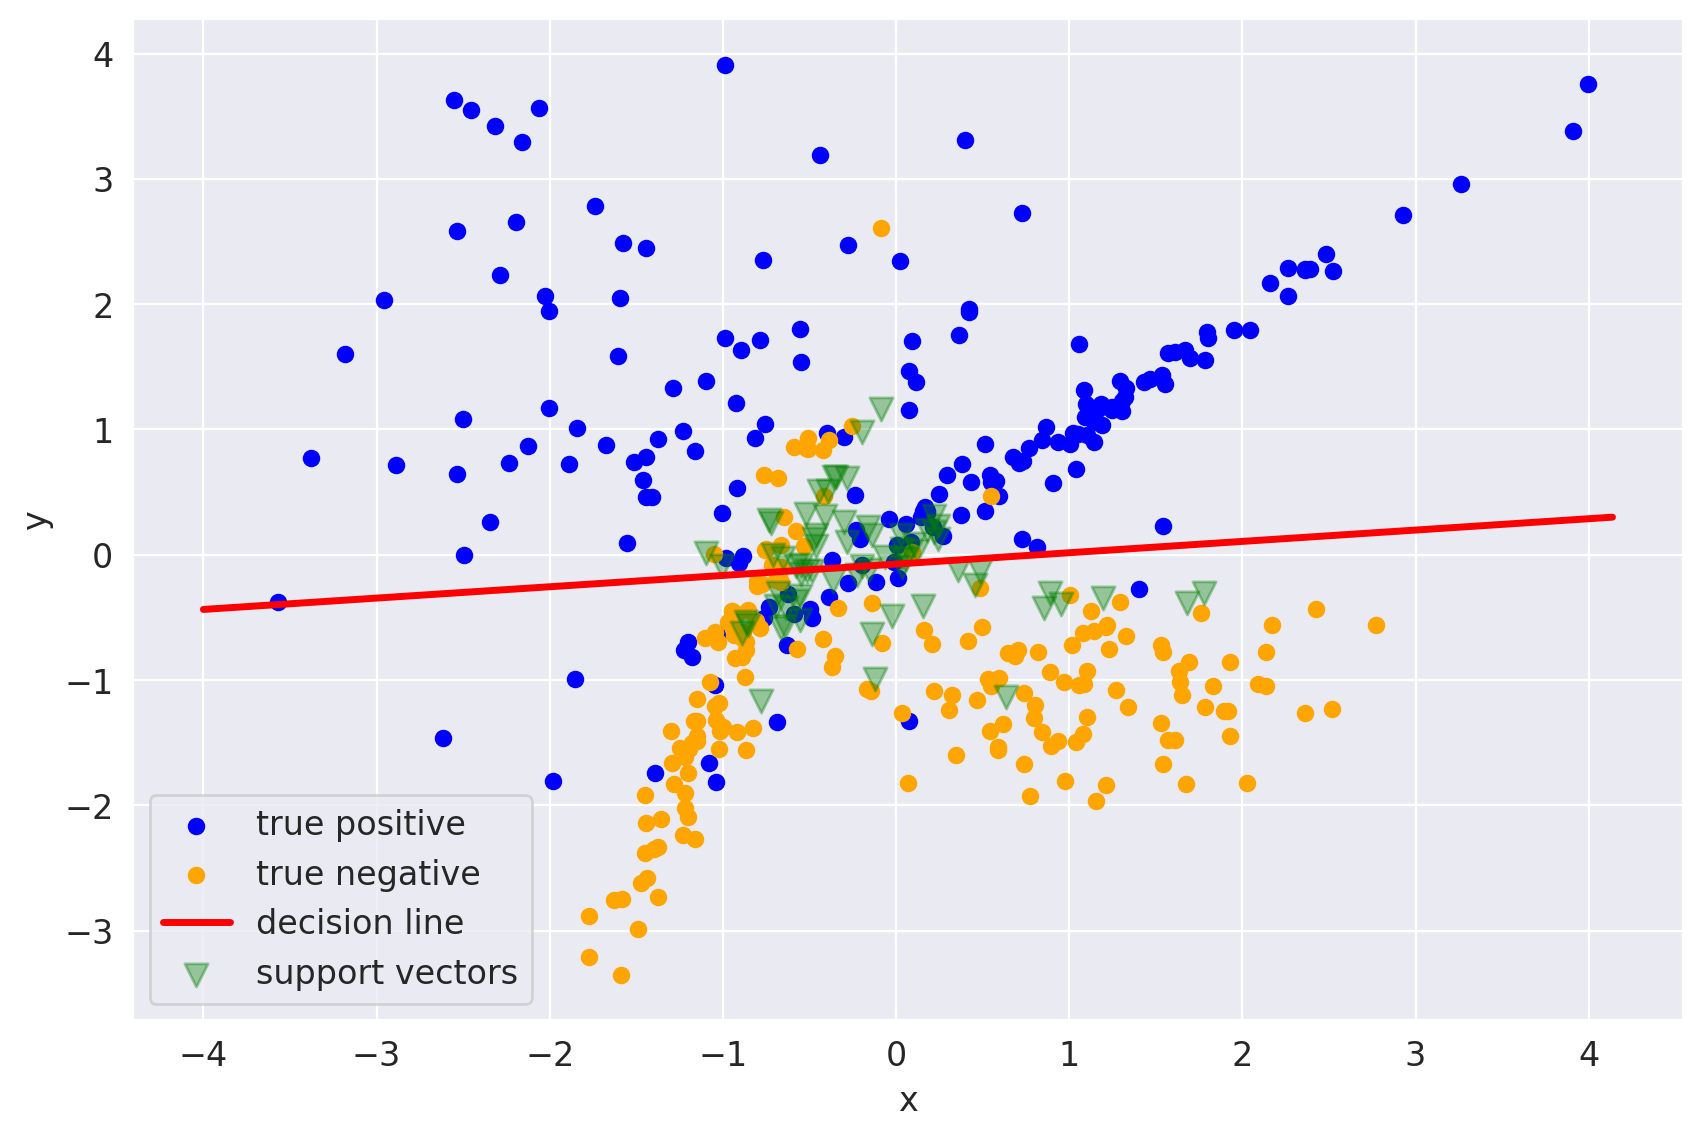

In [ ]:
# def plot_svm_2D(X, y, model,  plot_support=True):

#     #создали сетку
#     xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
#     yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
#     YY, XX = np.meshgrid(yy, xx)
#     xy = np.vstack([XX.ravel(), YY.ravel()]).T

#     #Ответы модели для сетки для отрисовки разделяющей прямой
#     Z = #your code here

#     plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


#     #Отрисовали выборку
#     plt.scatter(#your code here
#                 )

#     #Отрисовали опорные векторы
#     if plot_support:
#         plt.scatter(#your code here
#                    label='support vectors',
#                    s=100,
#                    linewidth=1,
#                    edgecolor="blue",
#                    facecolors='none')

#     plt.legend()

# plot_svm_2D(X, y, model)

# Visualisation SVM
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))

true_class_displayed = get_random_subsampling(X[y==1], cnt=180)
false_class_displayed = get_random_subsampling(X[y==0], cnt=180)
sup_vectors = get_random_subsampling(clf.support_vectors_, cnt=70)

plt.scatter(true_class_displayed[:, 0], true_class_displayed[:, 1],
            s=28, c='b', label='true positive')
plt.scatter(false_class_displayed[:, 0], false_class_displayed[:, 1],
            s=28, c='orange', label='true negative')
w = clf.coef_.reshape(-1)
intercept = clf.intercept_[0]
line = np.array([[-4, (-intercept + 4 * w[0]) / w[1]],
                 [(-intercept - 0.3 * w[1]) / w[0], 0.3]],)
plt.plot(line[:, 0], line[:, 1], c='r', linewidth=2.5, label='decision line')
plt.scatter(sup_vectors[:, 0], sup_vectors[:, 1],
            c='g', s = 70, alpha=0.36, marker='v',
            label='support vectors')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** объекты, которые ближе всего к разделяющей прямой, и которые влияют на ее положение (т.е. при удалении или добавлении нового опорного вектора изменится положение прямой)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
# def plot_logreg_2D(X, y, model):

#     #создали сетку
#     xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
#     yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
#     YY, XX = np.meshgrid(yy, xx)
#     xy = np.vstack([XX.ravel(), YY.ravel()]).T

#     #Ответы модели для сетки для отрисовки распределения
#     Z = #your code here
#     Z = Z.reshape((xx.shape[0], -1)).T


#     image = plt.imshow(Z, interpolation='nearest',
#                        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#                        aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

#     #Отрисовали выборку
#     plt.scatter(#your code here
#                 cmap=plt.cm.Paired)

#     plt.colorbar(image)


# plot_logreg_2D(X, y, model)
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2'))
])
pipe.fit(X, y)
pred = pipe.predict(X)

clf = pipe['clf']

Text(0, 0.5, 'y')

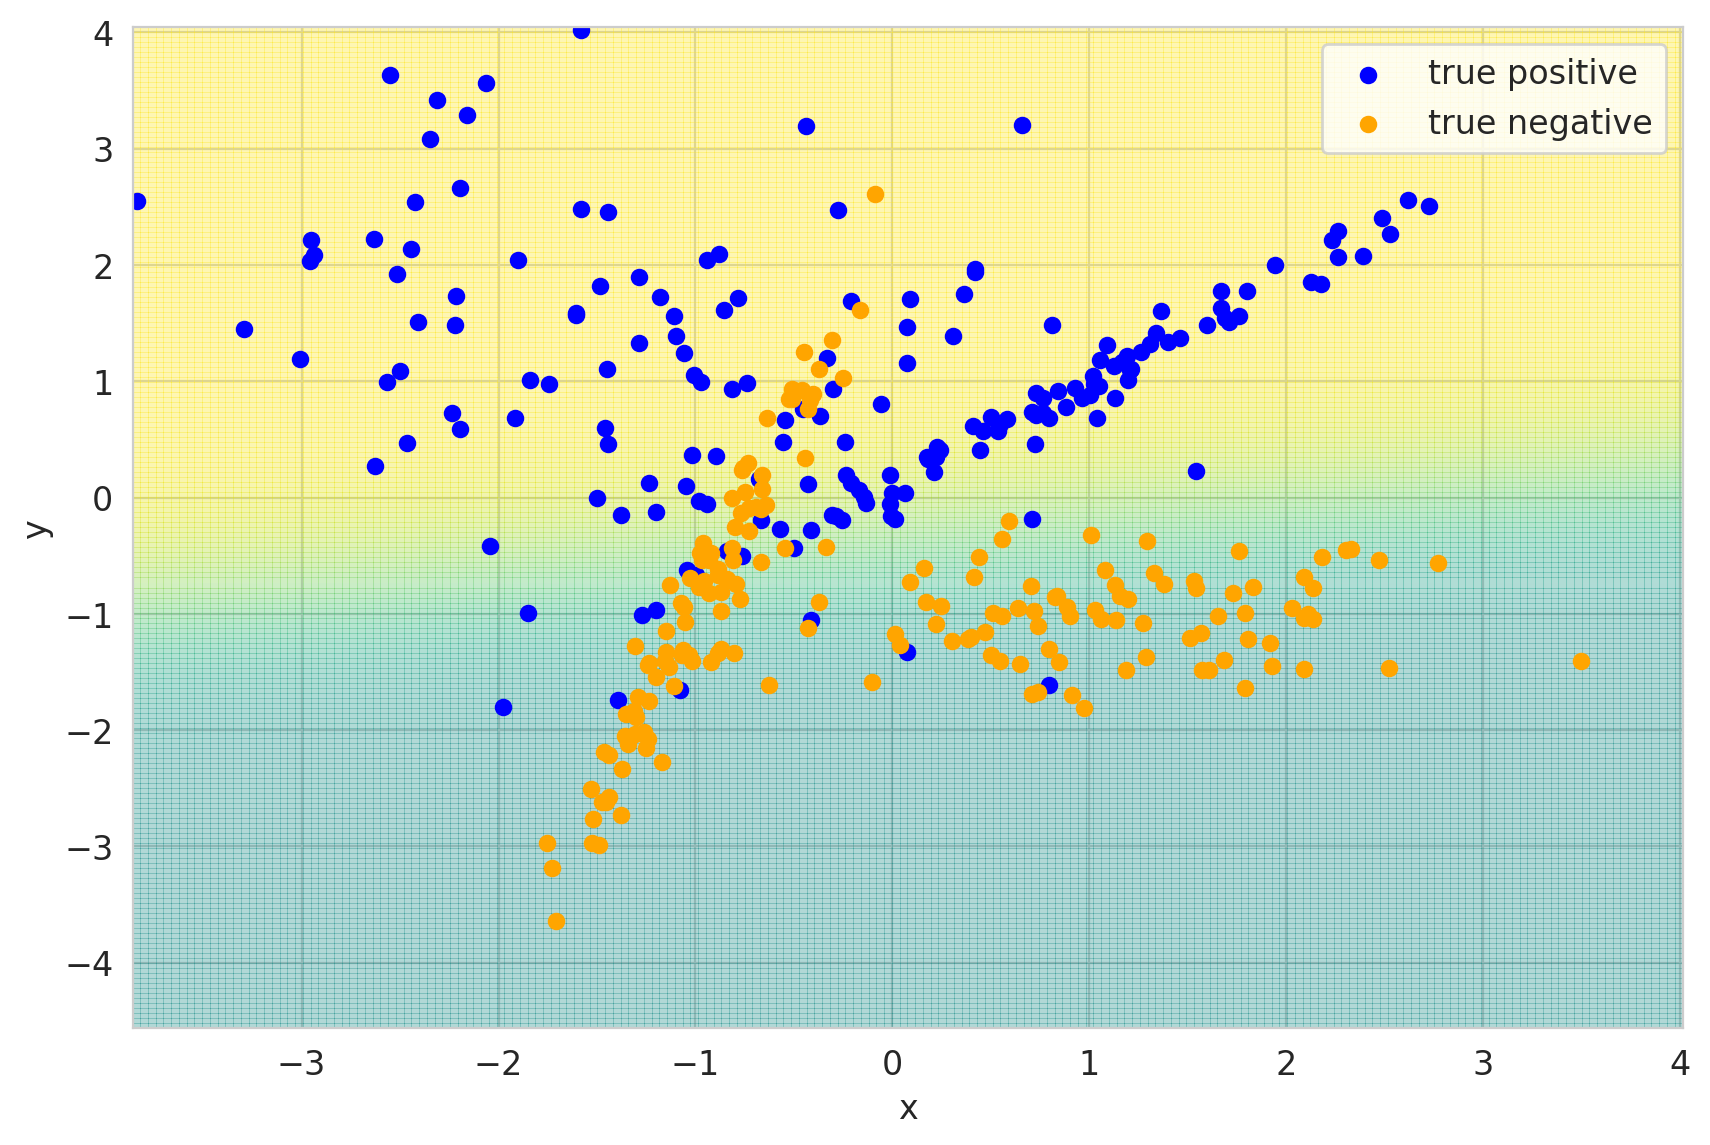

In [ ]:
# Visualisation LR
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))

true_class_displayed = get_random_subsampling(X[y==1], cnt=180)
false_class_displayed = get_random_subsampling(X[y==0], cnt=180)

grid = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
grid = np.concatenate(
    [np.tile(grid, grid.shape[0]).reshape(-1, 1),
    np.repeat(grid, grid.shape[0]).reshape(-1, 1)],
    axis=1
)
probabilities = clf.predict_proba(grid)[:, 1]

xgrid = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
ygrid = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
plt.pcolor(xgrid, ygrid, probabilities.reshape(-1, 200), vmin=-1, vmax=1, alpha=0.35, cmap='viridis')
plt.scatter(true_class_displayed[:, 0], true_class_displayed[:, 1],
            s=28, c='b', label='true positive')
plt.scatter(false_class_displayed[:, 0], false_class_displayed[:, 1],
            s=28, c='orange', label='true negative')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** #your answer here

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

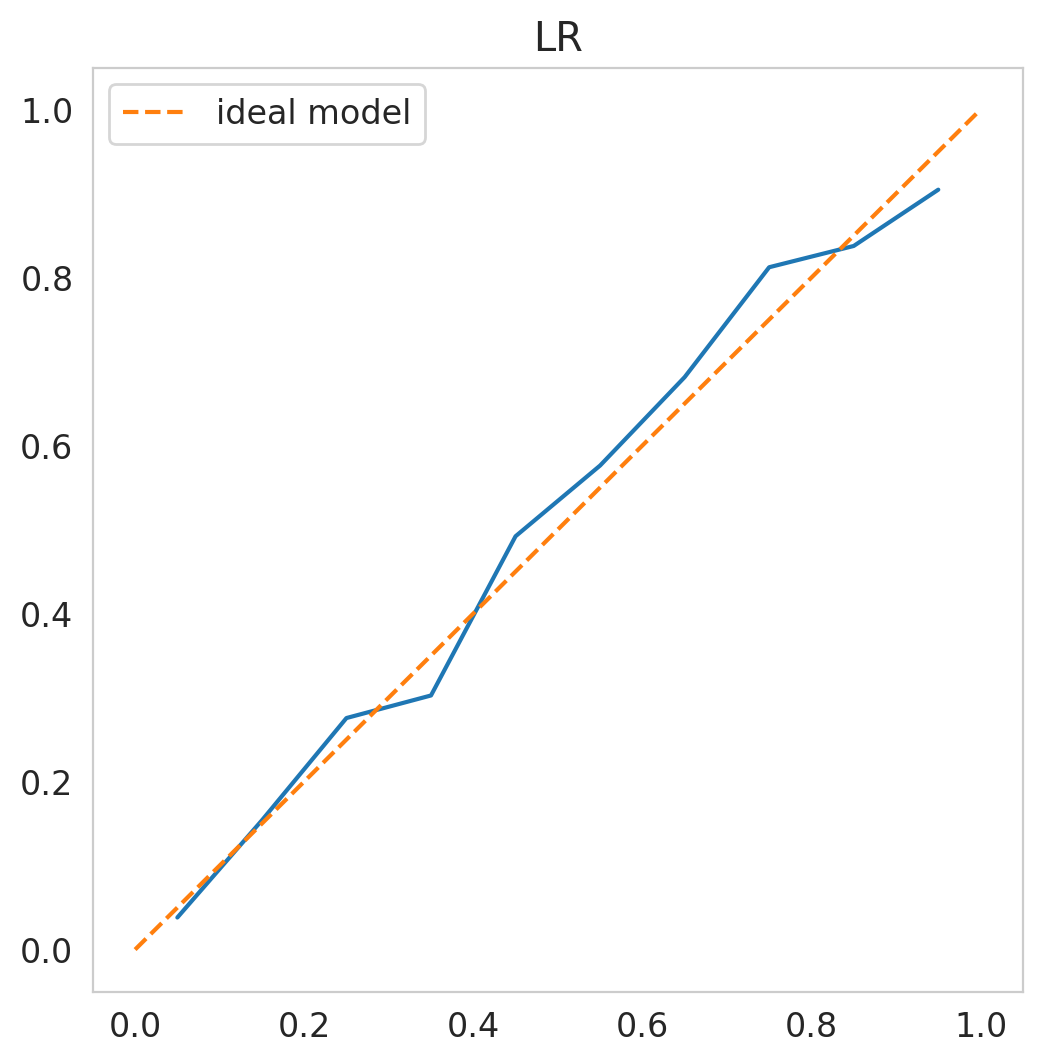

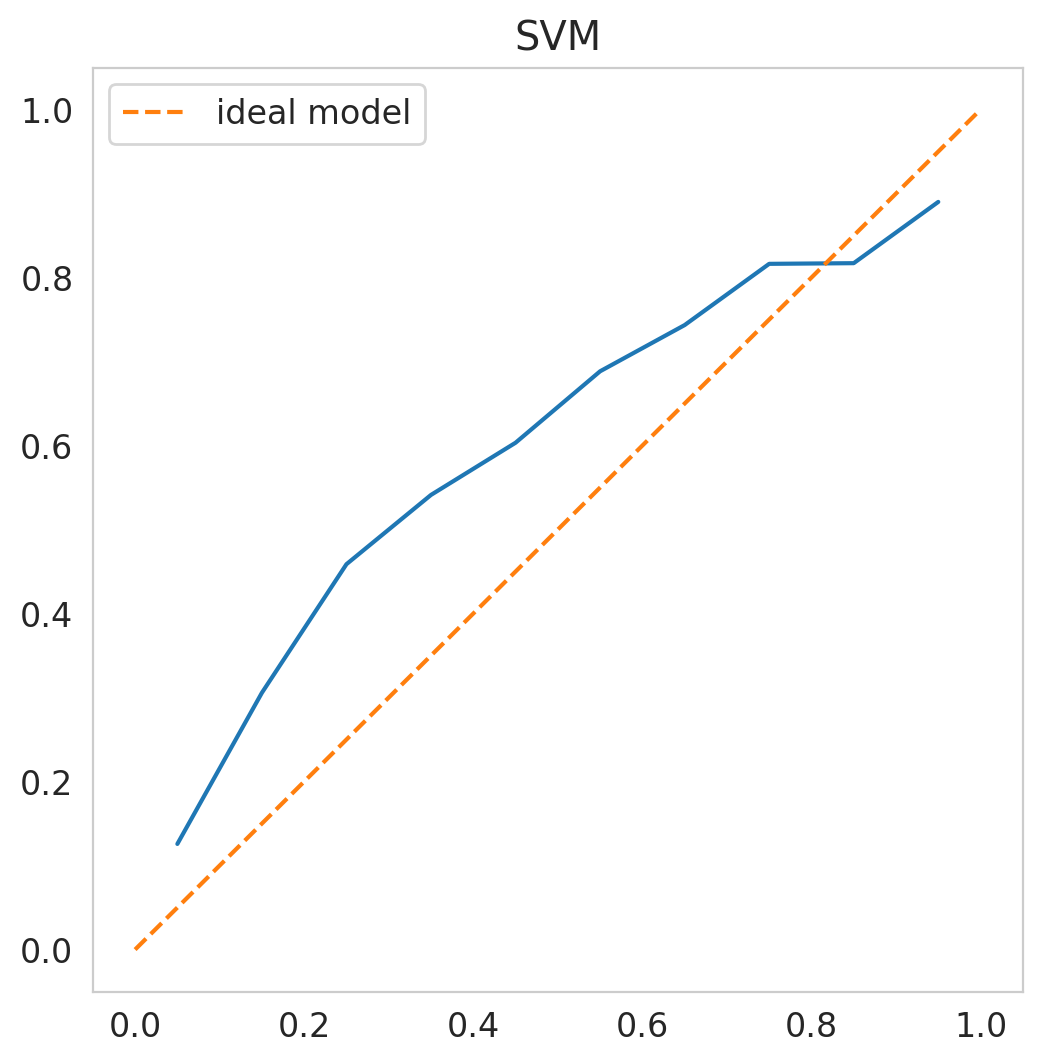

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LR
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2'))
])
pipe.fit(X_train, y_train)
pred_lr = pipe.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, pred_lr)
plt.title("LR")
plt.plot((0, 1), label="ideal model", linestyle="--")
plt.legend()

# SVM
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(kernel='linear'))
])
pipe.fit(X_train, y_train)

#pred_svm = pipe.predict_proba(X_test) ????
pred_svm = pipe['clf'].decision_function(X_test)
pred_svm = 1 / (1 + np.exp(-pred_svm))

plot_calibration_curve(y_test, pred_svm)

plt.title("SVM")
plt.plot((0, 1), label="ideal model", linestyle="--")
plt.legend()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** логистическая регрессия хорошо откалибрована. кривая для SVM проходит выше чем кривая идеально откалиброванной модели, это означает, что SVM занижает вероятности

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

Text(0.5, 1.0, 'SVM answers distr')

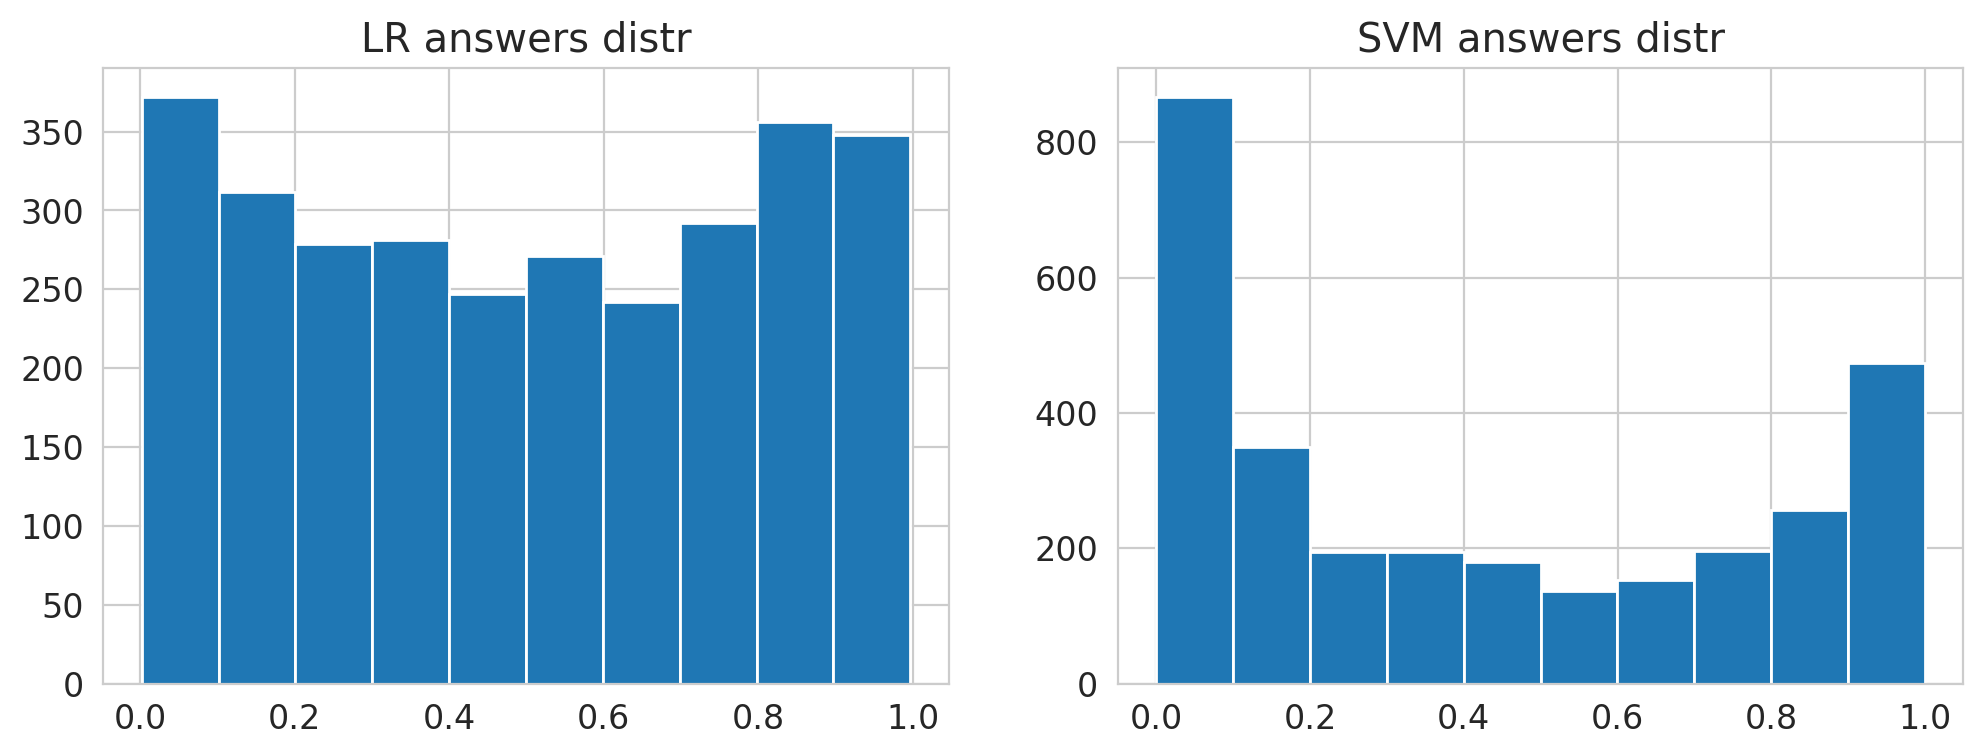

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(pred_lr)
ax[0].set_title("LR answers distr")
ax[1].hist(pred_svm)
ax[1].set_title("SVM answers distr")

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Логистическая регрессия распределяет ответы более равномерно, чем SVM, тогда как SVM отнес большое число объектов к отрицательному классу (выдал низкую вероятность принадлежности положительному классу)


Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

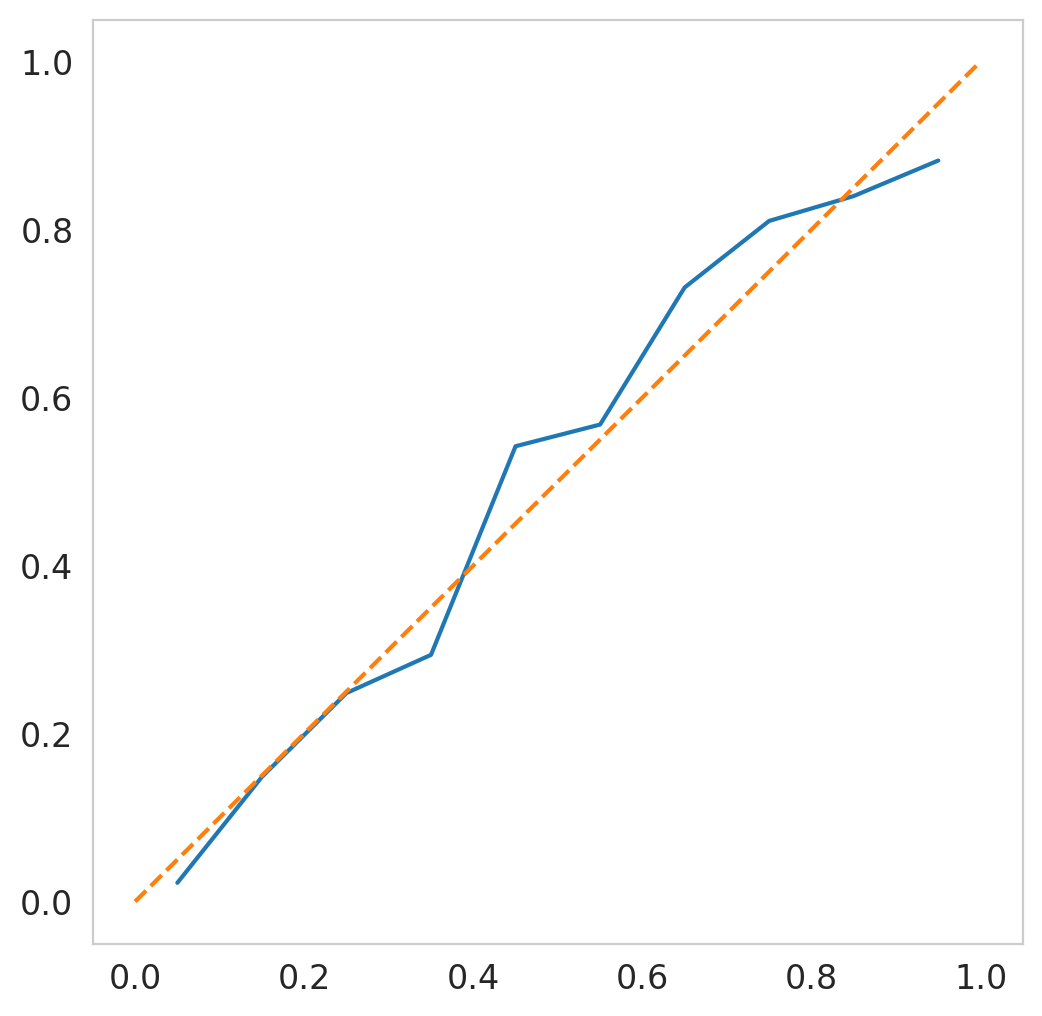

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(pipe)
calibrated_clf.fit(X_train, y_train)
probs = calibrated_clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probs)
plt.plot((0, 1), linestyle="--")

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Стало лучше, хотя модель все еще заметно отклоняется от идеальной и показывает качество предсказания вероятностей чуть хуже логистической регрессии, судя по этой кривой

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
#your code here
categorical = [
    "Marital Status", "Gender", "Education", "Occupation",
    "Home Owner", "Commute Distance", "Region"
]
numerical = [
    "Income", "Children", "Cars", "Age"
]
df[categorical] = df[categorical].fillna("undefined")


X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = df[numerical]
X_categorical = df[categorical]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from time import time

class Timer:

    def __enter__(self):
        self.time_start = time()
        return self

    def __exit__(self, err_type, err_val, err_tr):
        print(f"measured time: {time() - self.time_start} sec")
        return

enc = OrdinalEncoder()
model = LogisticRegression(max_iter=1000)

with Timer():
    X_train_encoded = enc.fit_transform(X_train)
    X_test_encoded = enc.transform(X_test)
    model.fit(X_train_encoded, y_train)

pred = model.predict_proba(X_test_encoded)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

measured time: 0.02471923828125 sec
AUC-PR: 0.57894


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
model = LogisticRegression(max_iter=1000)

with Timer():
    X_train_encoded = enc.fit_transform(X_train)
    X_test_encoded = enc.fit_transform(X_test)
    model.fit(X_train_encoded, y_train)

pred = model.predict_proba(X_test_encoded)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

measured time: 0.04639005661010742 sec
AUC-PR: 0.66186


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
with Timer():
    X_train_enc, X_test_enc = np.zeros(X_train.shape),  np.zeros(X_test.shape)

    for i, f in enumerate(categorical):
        unique_vals = X_train[f].unique()
        new_column_train = np.zeros(X_train.shape[0])
        new_column_test = np.zeros(X_test.shape[0])
        for val in unique_vals:
            mean_target_value = (y_train[X_train[f] == val].sum() /
                                    y_train[X_train[f] == val].count())
            new_column_train[X_train[f] == val] = mean_target_value
            new_column_test[X_test[f] == val] = mean_target_value

        X_train_enc[:, i] = new_column_train
        X_test_enc[:, i] = new_column_test

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_enc, y_train)

pred = model.predict_proba(X_test_enc)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

measured time: 0.04464459419250488 sec
AUC-PR: 0.65269


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin

class MeanTargetEncoder:
    def __init__(self, categorical, target):
        self.categorical = categorical
        self.target = target
        self.data = dict()

    def fit(self, x, y):
        n_features = x.shape[1] + 1
        df = x.copy()
        df[self.target] = y
        for feature in self.categorical:
            self.data[feature] = df[[feature, self.target]] \
                                .groupby(by=feature) \
                                .mean().transpose()
        return self

    def transform(self, df):
        new_df = df.copy()
        for feature in self.categorical:
            new_df[feature] = new_df[feature].apply(
                 lambda x: self.data[feature][x][0])
        return new_df


In [ ]:
mte = MeanTargetEncoder(categorical, 'Purchased Bike')
mte.fit(X_train, y_train)
mte.transform(X_train.head(5))

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079
110,0.552632,0.504155,0.437186,0.482759,0.489270,0.535581,0.488372
902,0.552632,0.463158,0.529915,0.478947,0.478599,0.566667,0.430079
15,0.552632,0.504155,0.466165,0.482759,0.478599,0.535581,0.488372


In [ ]:
X_train_enc = mte.transform(X_train).to_numpy()
X_test_enc = mte.transform(X_test).to_numpy()

# scaler = StandardScaler()
# scaler.fit(X_train_enc)
# X_train_enc, X_test_enc = scaler.transform(X_train_enc), scaler.transform(X_test_enc)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_enc, y_train)
pred = model.predict_proba(X_test_enc)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.65269


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:

rand_matrix = np.random.normal(loc=0.,
                               scale=0.01,
                               size=(X_train_enc.shape[0], len(categorical)))

X_train_enc += rand_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train_enc, y_train)
pred = model.predict_proba(X_test_enc)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.65232


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:**  Подавление шума  $\sim N(0, 0.01)$ действительно помогло. AUC-PR увеличился на 0.02!

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:

class MeanTargetEncoderSmoothing:
    def __init__(self, categorical, target, C=10.0):
        self.categorical = categorical
        self.target = target
        self.data = dict()
        self.C = C

    def fit(self, x, y):
        n_features = x.shape[1] + 1
        df = x.copy()
        df[self.target] = y
        global_mean = y.mean()
        for feature in self.categorical:
            statistics = df[[feature, self.target]] \
                                 .groupby(by=feature) \
                                 .agg(['sum', 'count'])
            statistics = statistics.droplevel(0, axis=1)
            statistics['smoothed'] = (statistics['sum'] + self.C * global_mean) / \
                                    (statistics['count'] + self.C)
            statistics = statistics.drop(columns=['sum', 'count'])
            self.data[feature] = statistics.transpose()
        return self

    def transform(self, df):
        new_df = df.copy()
        for feature in self.categorical:
            new_df[feature] = new_df[feature].apply(
                 lambda x: self.data[feature][x][0])
        return new_df


In [ ]:
mte = MeanTargetEncoderSmoothing(categorical, 'income', C=5)
mte.fit(X_train, y_train)
X_train_enc = mte.transform(X_train).to_numpy()
X_test_enc = mte.transform(X_test).to_numpy()

model = LogisticRegression(max_iter=1000)
model.fit(X_train_enc, y_train)
pred = model.predict(X_test_enc)

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67825


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
for f in numerical:
    X_numerical.loc[:, f].fillna(X_numerical[f].mean(), inplace=True)

<ipython-input-36-ad90109cb88c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_numerical.loc[:, f].fillna(X_numerical[f].mean(), inplace=True)


In [ ]:
X = pd.concat([X_categorical, X_numerical], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [ ]:
X_train[numerical].nunique()

Income      17
Children     7
Cars         6
Age         54
dtype: int64

In [ ]:
# Encode cat and num features with Mean Target Encoding together
mte = MeanTargetEncoderSmoothing(categorical + numerical, 'income', C=5)
mte.fit(X_train, y_train)
X_train_enc = mte.transform(X_train).to_numpy()
X_test_enc = mte.transform(X_test).to_numpy()

model = LogisticRegression(max_iter=3000)
model.fit(X_train_enc, y_train)
pred = model.predict(X_test_enc)

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.69364


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Большой плюc Mean Target Encoding заключается в том, что мы не плодим очень много признаков, как при использовании One Hot кодирования. При этом получаем результаты близкие, а иногда даже превосходящие One Hot. Минусы: Mean Target Encoding подвержен переобучению, поскольку целевая

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-21 14:01:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.34MB/s    in 0.5s    

2023-11-21 14:01:35 (7.34 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
23952,59,Private,81929,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,2415,45,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=777, stratify=df['income'])
y_train, y_test = train['income'], test['income']
train = train.drop(columns='income')
test = test.drop(columns='income')

categorical = ["workclass", "education", "marital-status",
               "occupation", "relationship", "race", "sex",
               "native-country"]
numerical = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical),
    ],
    remainder='passthrough',
    sparse_threshold=0
)
preprocessor.fit(train)
X_train, X_test = preprocessor.transform(train), preprocessor.transform(test)
X_train.shape[1] - df.shape[1]

93

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
model = LogisticRegression(max_iter=2000, penalty='l2')
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]

# count AUC-PR
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.45033


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
X_train, X_test = preprocessor.transform(train), preprocessor.transform(test)

def retain_n_features(model, X_train, X_test, n=40, return_features=False):
    lst = list(enumerate(model.coef_.reshape(-1).tolist()))
    lst = sorted(lst, key=lambda x: abs(x[1]), reverse=True)
    retained_features = np.array(list(map(lambda x: x[0], lst[:n])))
    if not return_features:
        return X_train[:, retained_features], X_test[:, retained_features]
    return (
        X_train[:, retained_features],
        X_test[:, retained_features],
        retained_features)

X_train, X_test, f = retain_n_features(model, X_train, X_test, return_features=True)

In [ ]:
new_model = LogisticRegression(max_iter=2000, penalty='l2')
new_model.fit(X_train, y_train)
pred = new_model.predict_proba(X_test)[:, 1]

# count AUC-PR
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76008


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical),
        ("scale", StandardScaler(), numerical)
    ],
    remainder='passthrough',
    sparse_threshold=0
)
preprocessor.fit(train)
X_train, X_test = preprocessor.transform(train), preprocessor.transform(test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

X_train, X_test, features = retain_n_features(model, X_train, X_test, return_features=True)

new_model = LogisticRegression(max_iter=2000)
new_model.fit(X_train, y_train)
pred = new_model.predict(X_test)

# count AUC-PR
precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

print(f'retained features : {features}')

AUC-PR: 0.69674
retained features : [105  26  27  41  64  52  22  29  36  37  62  61  66  50  71  70  30   8
  43  82 104  45   1  28  40  13  12  42  90  49  87  88  25  84  95  65
  68  72 100  69]


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical),
    ],
    remainder='passthrough',
    sparse_threshold=0
)

preprocessor.fit(df.drop(columns='income'))

pipe = Pipeline(
    steps=[
        ('trans', preprocessor),
        ('scale', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ]
)

pipe.fit(train, y_train)
pred = pipe.predict(test)

precision, recall, _ = precision_recall_curve(y_test, pred)
print(f'score before feature selection : {auc(recall, precision)}')

score before feature selection : 0.7184708034481659


In [ ]:
X_train, X_test = preprocessor.transform(train), preprocessor.transform(test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
X_train, X_test, features = retain_n_features(pipe['clf'], X_train, X_test, return_features=True)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, pred)
print(f'score after feature selection: {auc(recall, precision)}')

score after feature selection: 0.7151164585671379


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state=777, stratify=df['income'])
train, val = train_test_split(train, test_size=0.3, random_state=777, stratify=train['income'])

y_train, y_test, y_val = train['income'], test['income'], val['income']
train = train.drop(columns='income')
test = test.drop(columns='income')
val = val.drop(columns='income')

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical),
        ("scale", StandardScaler(), numerical),
    ],
    remainder='passthrough',
    sparse_threshold=0
)
preprocessor.fit(train)

X_train, X_test, X_val = preprocessor.transform(train), \
                         preprocessor.transform(test), \
                         preprocessor.transform(val)

In [ ]:
retained = set(list(range(1, 108)))
while len(retained) > 40:
    def get_score(f, retained):
        retained.remove(f)
        X_train_tmp = X_train[:, list(retained)]
        X_val_tmp = X_val[:, list(retained)]
        model = LogisticRegression(max_iter=300)
        model.fit(X_train_tmp, y_train)
        pred = model.predict(X_val_tmp)
        retained.add(f)
        return average_precision_score(y_val, pred)

    scores = np.array([[get_score(x, retained), x] for x in retained])
    retained.remove(scores[np.argmin(scores[:, 0])][1])

retained


KeyboardInterrupt: ignored

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-21 14:02:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.14MB/s    in 0.4s    

2023-11-21 14:02:34 (1.14 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df.dropna(inplace=True)
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
categorical = [
    "job", "education", "default", "housing", "loan", "contact", "month",
    "day_of_week", "campaign", "poutcome", "marital"
]
numerical = [
    "age", "pdays", "previous", "emp.var.rate", "cons.price.idx",
    "cons.conf.idx", "euribor3m", "nr.employed"
]
for train, test in kf.split(X):
    prepr = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
            ("scale", StandardScaler(), numerical),
        ],
        remainder='passthrough',
        sparse_threshold=0
    )
    prepr.fit(X.iloc[train])
    X_train_enc, X_test_enc = prepr.transform(X.iloc[train]), prepr.transform(X.iloc[test])
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_enc, y.iloc[train])
    pred = model.predict(X_test_enc)

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
categorical = [
    "job", "education", "default", "housing", "loan", "contact", "month",
    "day_of_week", "campaign", "poutcome", "marital"
]
numerical = [
    "age", "pdays", "previous", "emp.var.rate", "cons.price.idx",
    "cons.conf.idx", "euribor3m", "nr.employed"
]


def get_revenues_and_calls(kf, f, C=1.0):
    revenues = []
    calls = []
    for train, test in kf.split(X):
        prepr = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
                ("scale", StandardScaler(), numerical),
            ],
            remainder='passthrough',
            sparse_threshold=0
        )
        prepr.fit(X.iloc[train])
        X_train_enc, X_test_enc = prepr.transform(X.iloc[train]), prepr.transform(X.iloc[test])
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_enc, y.iloc[train])
        pred = model.predict(X_test_enc).astype(np.int32)
        calls.append(pred.sum())
        d = pred * y.iloc[test].to_numpy().astype(np.int32)
        revenues.append(d.sum() * f())
    return revenues, calls

In [ ]:
revenues, calls = get_revenues_and_calls(kf, lambda: 10)
revenues = np.array(revenues)
calls = np.array(calls)
print(f"average revenue : {revenues.mean()}")
print(f"average expenses : {calls.mean()}")
print(f"revenue's standard deviation : {revenues.std()}")

average revenue : 2136.0
average expenses : 324.8
revenue's standard deviation : 97.89790600416333


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
revenues, calls = get_revenues_and_calls(kf, lambda: np.random.uniform(low=0., high=20.))
revenues = np.array(revenues)
calls = np.array(calls)
print(f"average revenue : {revenues.mean()}")
print(f"average expenses : {calls.mean()}")
print(f"revenue's standard deviation : {revenues.std()}")

average revenue : 2713.3997168820024
average expenses : 324.8
revenue's standard deviation : 1390.8411853077798


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
prepr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical)
    ],
    remainder='passthrough',
    sparse_threshold=0
)
estimators = [
    ("prepr", prepr),
    ('clf', LogisticRegression(max_iter=1000))]
pipe = Pipeline(estimators)

from sklearn.metrics import make_scorer

def income_score(y_true, y_pred, f=lambda: np.random.uniform(high=20.0)):
    pred = model.predict(X_test_enc).astype(np.int32)
    d = y_true * y_pred
    return d.sum() * f() - pred.sum()
score = make_scorer(income_score, greater_is_better=True)

C = np.linspace(1e-3, 10, 5)
searcher = GridSearchCV(pipe, [{"clf__C": C}], scoring=score, cv=3)
searcher.fit(X, y.to_numpy().astype(np.int32))
best_C = searcher.best_params_['clf__C']
print("best C:", best_C)

best C: 10.0


<ErrorbarContainer object of 3 artists>

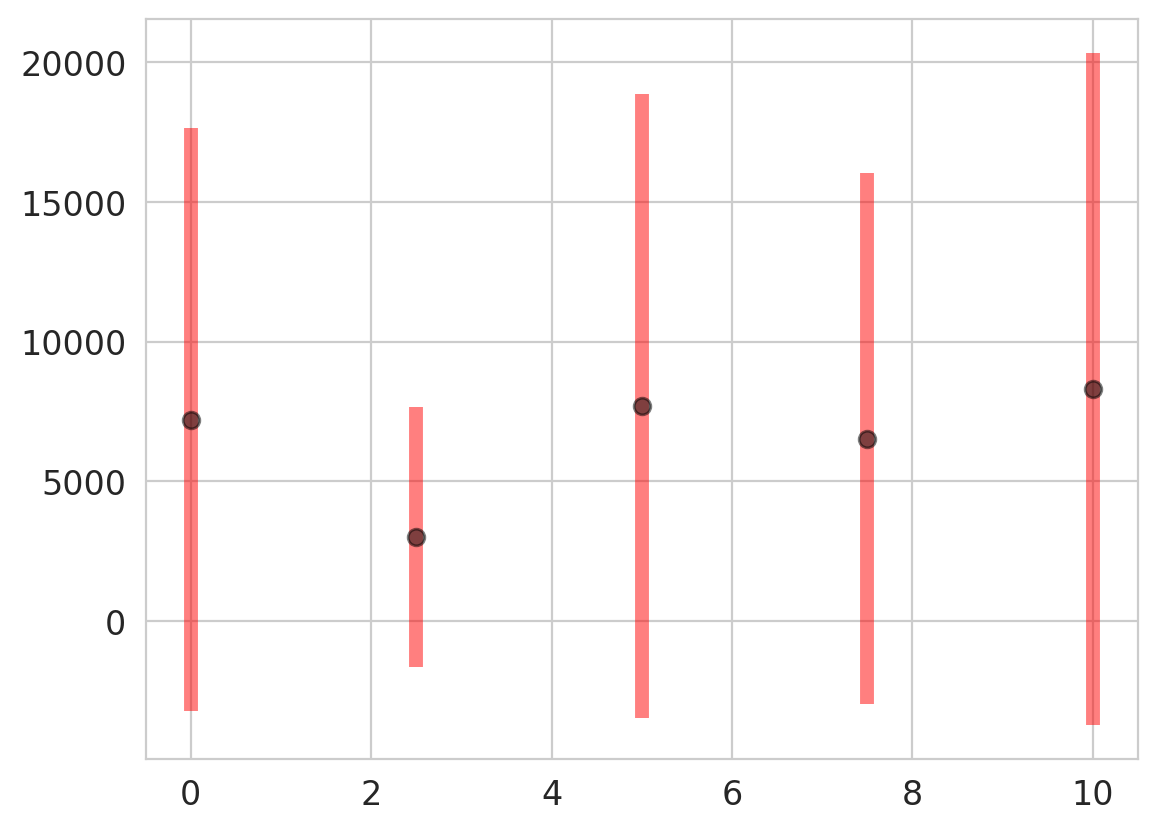

In [ ]:
# params = searcher.cv_results_["params"]

mean_test_scores = searcher.cv_results_["mean_test_score"]
std_test_scores = searcher.cv_results_["std_test_score"]
sns.set_style("whitegrid")
plt.errorbar(C, mean_test_scores, yerr=std_test_scores,
             fmt='o',
             ecolor="red",
             color="black",
             elinewidth=5, capsize=0, alpha=0.5)

Прибыль максимальна при C = 2.5.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
C = np.linspace(1e-3, 10, 5)

for exp in range(3):
    searcher = GridSearchCV(pipe, [{"clf__C": C}], scoring=score, cv=3)
    searcher.fit(X, y.to_numpy().astype(np.int32))
    best_C = searcher.best_params_['clf__C']
    print(f"best C in exp {exp}: {best_C}")

best C in exp 0: 10.0
best C in exp 1: 10.0
best C in exp 2: 7.50025


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ прибыль вычисляется как:

$TP \cdot f  - TP - FP$, где $f \sim U[0, 20]$

$\mathbb{E}[TP(f - 1)] - \mathbb{E}[FP] = 9\mathbb{E}[TP] - \mathbb{E}[FP] \to max$

Соответственно, нам выгодно минимизировать FP, а значит precision важнее


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
import warnings

kf = KFold(n_splits=2, shuffle=True, random_state=500)
bin_treshold = np.flip(np.linspace(0, 1, num=100))
mean_profits = []
std_profits = []

precisions = []
recalls = []

eps = 1e-7

# choose treshold
for t in bin_treshold:
    profits = []
    precisions.append([])
    recalls.append([])
    print(t, end=" ")
    for train, test in kf.split(X):
        # data prepr
        prepr = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
                ("scale", StandardScaler(), numerical),
            ],
            remainder='passthrough',
            sparse_threshold=0
        )
        prepr.fit(X.iloc[train])
        # get encoded data
        X_train_enc, X_test_enc = prepr.transform(X.iloc[train]), prepr.transform(X.iloc[test])

        # fit model
        model = LogisticRegression()
        with warnings.catch_warnings() as w:
            warnings.simplefilter("ignore")
            model.fit(X_train_enc, y.iloc[train])

        # get predictions
        pred = model.predict_proba(X_test_enc)[:, 1]
        pred = (pred >= t).astype(np.int32)

        # d = true positive predictions
        d = y.iloc[test].to_numpy().astype(np.int32) * pred
        # get profits
        profits.append(d.sum() * np.random.uniform(high=20.) - pred.sum())

        precision = d.sum() / (pred.sum() + eps)
        recall = d.sum() / y.iloc[test].to_numpy().astype(np.int32).sum()

        precisions[-1].append(precision)
        recalls[-1].append(recall)

    profits = np.array(profits)
    mean_profits.append(profits.mean())
    std_profits.append(profits.std())



1.0 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.98989898989899 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9797979797979799 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9696969696969697 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9595959595959597 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9494949494949496 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9393939393939394 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9292929292929294 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()
<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9191919191919192 

<ipython-input-117-843817d1dc16>:46: RuntimeWarning: invalid value encountered in long_scalars
  precision = d.sum() / pred.sum()


0.9090909090909092 0.8989898989898991 0.888888888888889 0.8787878787878789 0.8686868686868687 0.8585858585858587 0.8484848484848485 0.8383838383838385 0.8282828282828284 0.8181818181818182 0.8080808080808082 0.797979797979798 0.787878787878788 0.7777777777777778 0.7676767676767677 0.7575757575757577 0.7474747474747475 0.7373737373737375 0.7272727272727273 0.7171717171717172 0.7070707070707072 0.696969696969697 0.686868686868687 0.6767676767676768 0.6666666666666667 0.6565656565656566 0.6464646464646465 0.6363636363636365 0.6262626262626263 0.6161616161616162 0.6060606060606061 0.595959595959596 0.5858585858585859 0.5757575757575758 0.5656565656565657 0.5555555555555556 0.5454545454545455 0.5353535353535354 0.5252525252525253 0.5151515151515152 0.5050505050505051 0.494949494949495 0.48484848484848486 0.4747474747474748 0.4646464646464647 0.4545454545454546 0.4444444444444445 0.43434343434343436 0.42424242424242425 0.4141414141414142 0.4040404040404041 0.393939393939394 0.383838383838383

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




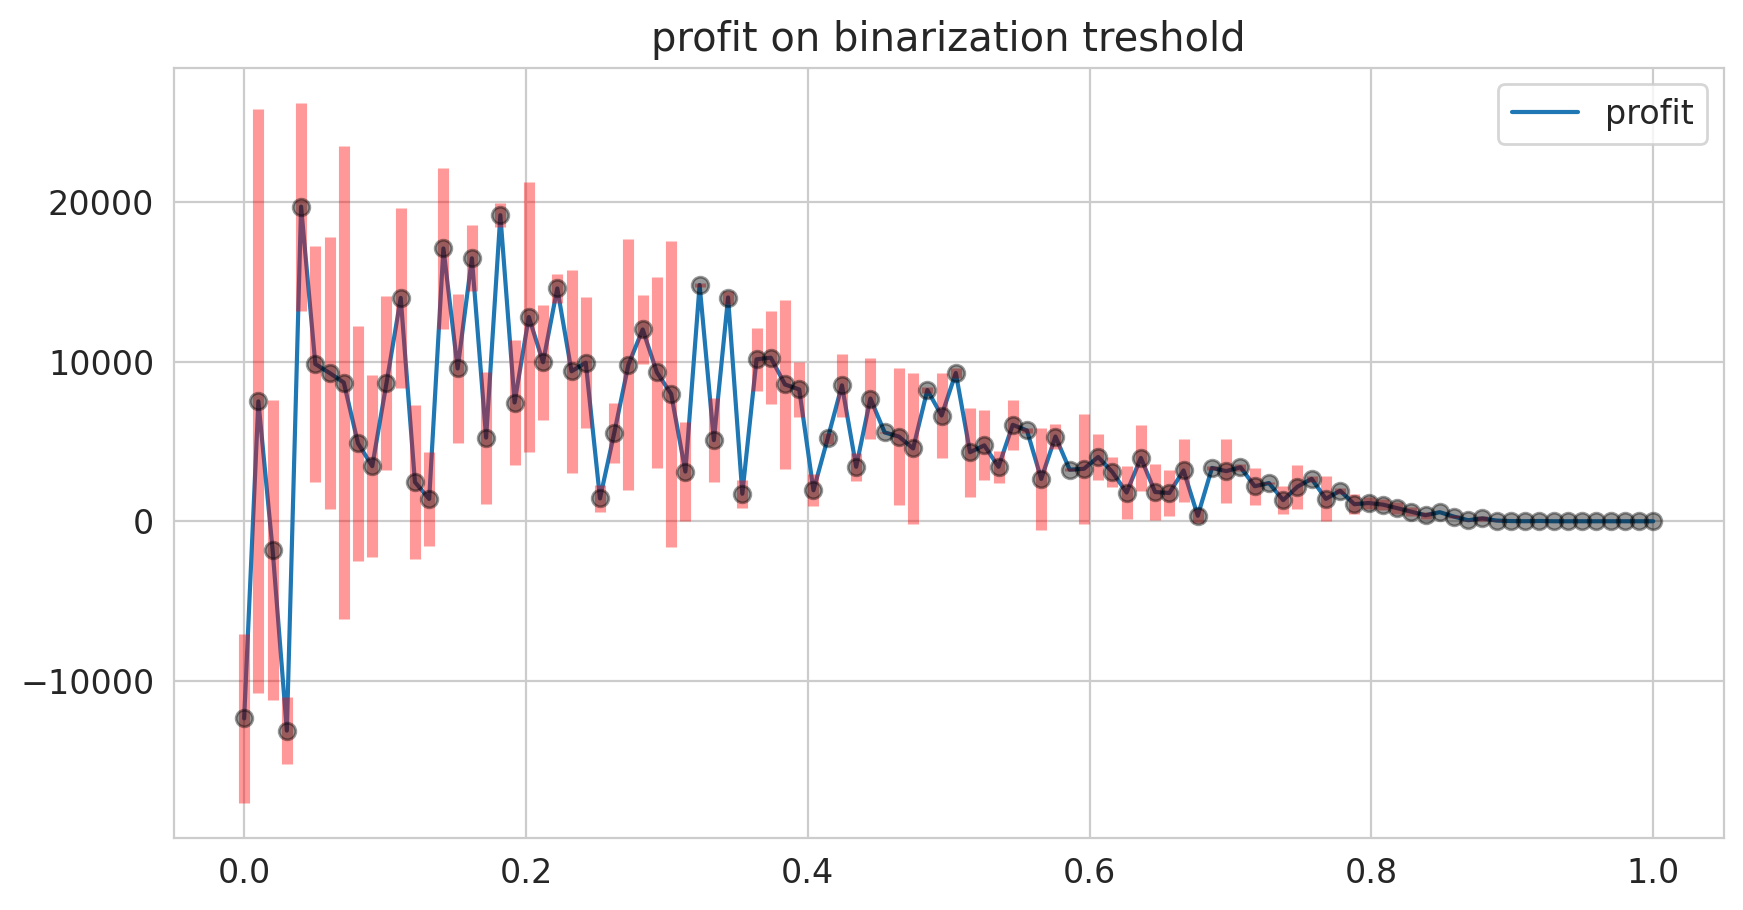

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("profit on binarization treshold")
plt.plot(bin_treshold, mean_profits, label="profit")
plt.errorbar(bin_treshold, mean_profits, yerr=std_profits,
             fmt='o',
             ecolor="red",
             color="black",
             elinewidth=4, capsize=0, alpha=0.4)
plt.legend()

In [ ]:
best_treshold_idx = np.argmax(np.array(mean_profits))
best_treshold = bin_treshold[best_treshold_idx]
best_treshold

0.8383838383838385

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
precisions = np.array(precisions)
recalls = np.array(recalls)
print(f"Precision: {precisions[best_treshold_idx].mean()}\nPrecision STD: {precisions[best_treshold_idx].std()}")
print(f"Recall: {recalls[best_treshold_idx].mean()}\nRecall STD: {recalls[best_treshold_idx].std()}")


Precision: 0.11040319098306778
Precision STD: 0.0016057658392074486
Recall: 0.976670566797309
Recall STD: 0.005403696967095639


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
new_recalls = np.mean(recalls, axis=1)
new_precisions = np.mean(precisions, axis=1)
new_precisions = new_precisions[new_recalls >= 0.5]
new_recalls = new_recalls[new_recalls >= 0.5]

seq = list(zip(new_precisions, new_recalls))
seq = sorted(seq, key=lambda x: x[1])

assert len(seq) >= 2
last_pr = seq[0][0]
last_rec = seq[0][1]
first_rec = seq[0][1]
first_pr = seq[0][0]
total_area = 0

for i, (pr, rec) in enumerate(seq[1:]):
    delta_r = rec - last_rec
    x = delta_r / (1. - first_rec)
    total_area += x * pr / first_pr
    last_rec = rec

print(f"AUC-PR for recall >= 0.5:\n{total_area}")

AUC-PR for recall >= 0.5:
1.3797755488231085


Text(0, 0.5, 'precision')

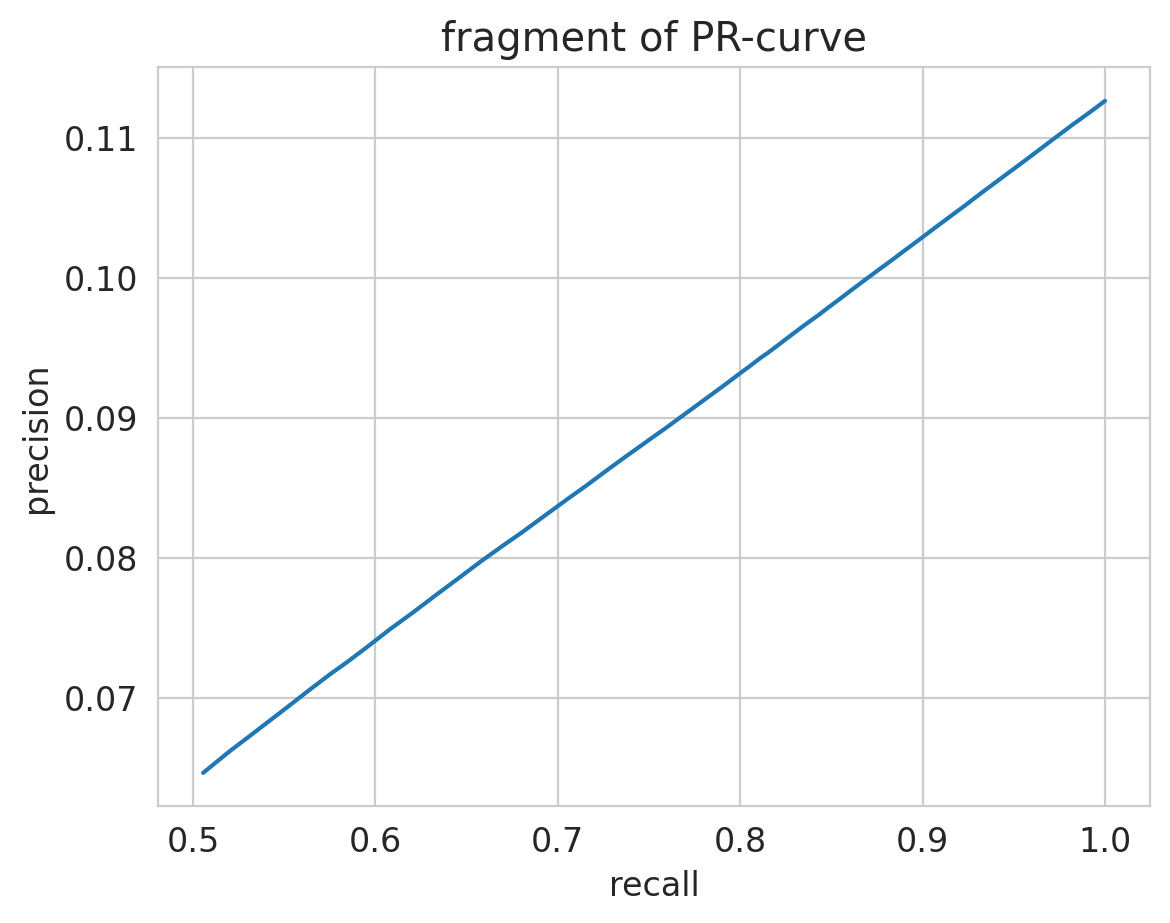

In [ ]:
plt.plot(new_recalls, new_precisions)
plt.title("fragment of PR-curve")
plt.xlabel("recall")
plt.ylabel("precision")

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here